# Deep Neural Network Ensembles

This chapter considers the method of 'bagging' for deep neural network predictions. Insead of a single hypothesis, we create hypotheses $h_{1},h_{2},\dots h_{n}$ and form an ensemble prediction. For regression tasks the final prediction of the ensemble could be the mean and for classification the mode. The idea of bagging is to form a moderate learner out of several weak learners. An important property is that the final learner is improved the more uncorrelated the single weak learners are. The idea of bagging goes back to `cite`{Breiman1996} and is a shorthand for bootstrap-aggregation, indicating the two important steps bootstrapping and aggregating

In [846]:
import torch
from torch.nn import Sequential
import numpy as np
from sklearn.datasets import load_wine, load_diabetes
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from scipy.stats import mode

In [847]:
SEED = 123
torch.manual_seed(SEED)
torch.set_default_dtype(torch.float64)
rng = np.random.default_rng(SEED)
sns.set_style("whitegrid")
mpl.rcParams['figure.figsize'] = (5, 3)

In [848]:
n_models = 50
X_wine, y_wine = load_wine(return_X_y = True)
X_diabetes, y_diabetes = load_diabetes(return_X_y = True)
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(X_wine, y_wine,
                                                                        test_size=1,
                                                                        random_state = SEED)
X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = train_test_split(X_diabetes, y_diabetes,
                                                                                        test_size = 1,
                                                                                        random_state = SEED)

Let us first create some useful functions to make the training and creation of an ensemble a bit more handy and hopefully less cluttered. We write functions that initialize some random fully connected architecture in `nn_layers_factory` which is used to create a fully connected neural network class with `instantiate_nn`. Since `nn_layers_factory` just created the hidden layer we need to take some adjustments to account for the size of input features and the output using the function `nn_factory`.

In [849]:
def nn_layers_factory(layers_min: int = 3, layers_max: int = 8, neurons_min: int = 5, neurons_max: int = 20) -> Sequential:
    """
    Create a DNN architecture with random number of neurons and layers.
    """
    
    n_layers = np.random.randint(layers_min,layers_max)
    neurons = np.random.randint(neurons_min,neurons_max,n_layers)
    # lambda expression needed to enforce direct evaluation
    layers = [torch.nn.Linear(neurons[(lambda x: x)(idx)], neurons[(lambda x: x + 1)(idx)]) for idx in range(len(neurons)-1)]
    layers = {f"layer_{idx+1}": layers[idx] for idx in range(len(layers))}
    activations = [torch.nn.ReLU()] * len(layers)
    activations = {f"activation_{idx+1}": activations[idx] for idx in range(len(activations))}
    names = [name for pair in zip(list(layers.keys()), list(activations.keys())) for name in pair]
    components = [value for pair in  zip(list(layers.values()), list(activations.values())) for value in pair]
    net = torch.nn.Sequential()

    for component, name  in zip(components, names):
        net.add_module(name, component)

    return net

In [850]:
def nn_factory(n_features: int, n_output: int, classification = True) -> Sequential:
    """
    Call nn_layer_factory to create random architecture and adjust for input and output.
    """
    
    net = nn_layers_factory()
    # adjustment for input and output
    first_layer = net[0]
    last_layer = net[-2]
    last_activation = net[-1]
    if classification:
        adjusted_last_activation = torch.nn.Softmax(dim=1)
    else:
        adjusted_last_activation = last_activation
        
    adjusted_first_layer = torch.nn.Linear(n_features, first_layer.out_features)
    adjusted_last_layer = torch.nn.Linear(last_layer.in_features, n_output, bias = False)
    
    # put it all together
    net[0] = adjusted_first_layer
    net[-1] = adjusted_last_activation
    net[-2] = adjusted_last_layer

    return net[0:-1]

In [851]:
def instantiate_nn(architecture):
    """
    Instantiate DNN model from adjusted architecture.
    """
    class CustomNet(torch.nn.Module):
        def __init__(self, architecture):
            super(CustomNet, self).__init__()
            self.seq_model = architecture
    
        def forward(self, x):
            return self.seq_model(x)
    net = CustomNet(architecture)
    return net

In [852]:
def train_model(nn, X_train, y_train, classification = True, n_epochs = 800, bootstrap = True, boot_size = 0.75):
    """
    Train a singe DNN.
    """

    # create boostrap sample
    if bootstrap:
        assert boot_size > 0 and boot_size < 1
        idx = np.arange(X_train.shape[0])
        n_boot = int(np.ceil(int(boot_size * len(idx))))
        idx_boot = np.random.choice(idx, size = n_boot, replace=False)
        X_train = X_train[idx_boot]
        y_train = y_train[idx_boot]

    X_train = torch.from_numpy(X_train)
    y_train = torch.from_numpy(y_train)
    
    learning_rate = 0.001
    
    if classification:
        criterion = torch.nn.CrossEntropyLoss()
    else:
        criterion = torch.nn.MSELoss()
        y_train = y_train.unsqueeze(1)
        
    optimizer = torch.optim.Adam(nn.parameters(), lr=learning_rate)

    # train for n_epochs
    acc_loss = []
    for epoch in range(n_epochs):
        nn.train()
    
        # Forward pass
        outputs = nn(X_train)
        loss = criterion(outputs, y_train)
        acc_loss.append(loss.detach().item())
    
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return acc_loss

In [853]:
def create_model_ensemble(X_train, n_outputs, n_models = 20):
    """
    Create list of DNN models.
    """
    
    ensemble = list()
    n_features = X_train.shape[1]
    print(f"Create ensemble with {n_features} features and {n_outputs} outputs.")
    
    for idx in range(n_models):
        model_architecture = (lambda x: x) (nn_factory(n_features, n_outputs))
        model_class = (lambda x: x) (instantiate_nn(model_architecture))
        ensemble.append(model_class)
    return ensemble

In [854]:
def train_ensemble(ensemble, X_train, y_train, classification = True, n_epochs = 500, bootstrap = True, boot_size = 0.75):
    """
    Train the ensemble.
    """
    
    trained_ensemble = list()
    losses = list()
    for model in ensemble:
        if classification:
            loss = (lambda x: x)(train_model(model, X_train, y_train, True, n_epochs, bootstrap, boot_size))
        else:
            loss = (lambda x: x)(train_model(model, X_train, y_train, False, n_epochs, bootstrap, boot_size))
        losses.append(loss)
    return losses

In [855]:
def predict_model(model, X_test, classification = True):
    X_test = torch.from_numpy(X_test)
    model.eval()
    with torch.no_grad():
        pred = model(X_test).numpy()
        if classification:
           pred = pred.argmax(axis = 1)
    return pred

def get_ensemble_predictions(trained_ensemble, X_test, classification = True):
    predictions = list()
    for model in trained_ensemble:
        model_pred = predict_model(model, X_test, classification)
        predictions.append(model_pred)
    predictions = np.concatenate(predictions, axis = 0)
    return predictions

In [856]:
def plot_ensemble(losses, predictions, y_test, classification = True, xlab = None, ylab = None, title = None):

    if classification:
        if xlab is None:
            xlab = "Classes"
        if ylab is None:
            ylab = "Counts"
        if title is None:
            title = f"Result of {len(predictions)} predictions on Classification Task (true class: {y_test_wine.item()})"
    
        unique_values, counts = np.unique(predictions, return_counts=True)
        predicted_classes =  pd.DataFrame({"Classes": unique_values,"Counts": counts})

        plt.bar(predicted_classes["Classes"].astype(str), predicted_classes["Counts"])
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        plt.title(title)
        
    else:

        # calculate std:
        std = np.std(predictions)
        # calculate mean
        mu = np.mean(predictions)
        # calculate variation coefficient
        cv = std / mu
        
        if xlab is None:
            xlab = "x"
        if ylab is None:
            ylab = "$\hat{y}=f(x)$"
        if title is None:
            title = "Result of preds predictions on Regression Task\n$\hat{\sigma}=std$, CV=varcoef, $\hat{\mu}=armean$, $y_{query}=y_true$"
            title = title.replace("preds", str(int(len(predictions))))
            title = title.replace("std", str(np.round(std, 2)))
            title = title.replace("varcoef", str(np.round(cv, 2)))
            title = title.replace("armean", str(np.round(mu, 2)))
            title = title.replace("y_true", str(np.round(y_test.item(), 2)))
            
     
        plt.hist(predictions)
        plt.xlabel(xlab)
        plt.ylabel(ylab)
        plt.title(title)

### Experiment I (model ensemble and bootstrap)

In [857]:
ensemble_wine = create_model_ensemble(X_train_wine, n_outputs = 3, n_models = n_models)

Create ensemble with 13 features and 3 outputs.


In [858]:
ensemble_diabetes = create_model_ensemble(X_train_diabetes, n_outputs = 1, n_models = n_models)

Create ensemble with 10 features and 1 outputs.


In [859]:
losses_diabetes = train_ensemble(ensemble_diabetes, X_train_diabetes, y_train_diabetes, classification = False)

In [860]:
losses_wine = train_ensemble(ensemble_wine, X_train_wine, y_train_wine, classification = True)

In [861]:
predictions_wine = get_ensemble_predictions(ensemble_wine, X_test_wine, classification = True)
predictions_diabetes = get_ensemble_predictions(ensemble_diabetes, X_test_diabetes, classification = False).squeeze()

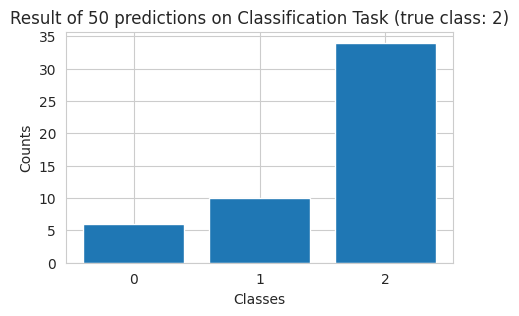

In [862]:
plot_ensemble(losses_wine, predictions_wine, y_test_wine, classification = True)

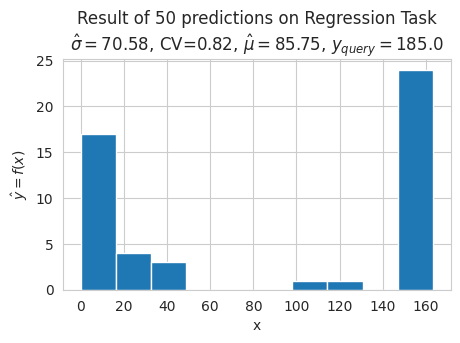

In [863]:
plot_ensemble(losses_diabetes, predictions_diabetes, y_test_diabetes, classification = False)

### Experiment II (model ensemble and no bootstrap)

In [864]:
losses_diabetes = train_ensemble(ensemble_diabetes, X_train_diabetes, y_train_diabetes, classification = False, bootstrap = False)

In [865]:
losses_wine = train_ensemble(ensemble_wine, X_train_wine, y_train_wine, classification = True, bootstrap = False)

In [866]:
predictions_wine = get_ensemble_predictions(ensemble_wine, X_test_wine, classification = True)
predictions_diabetes = get_ensemble_predictions(ensemble_diabetes, X_test_diabetes, classification = False).squeeze()

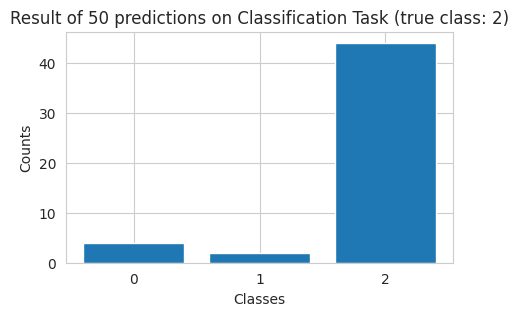

In [867]:
plot_ensemble(losses_wine, predictions_wine, y_test_wine, classification = True)

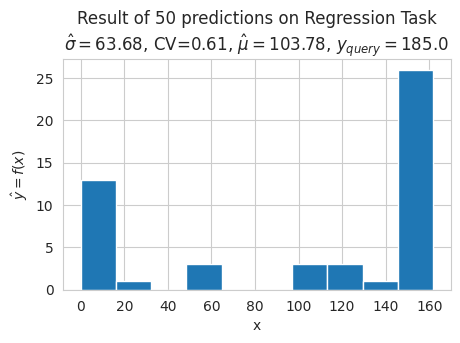

In [868]:
plot_ensemble(losses_diabetes, predictions_diabetes, y_test_diabetes, classification = False)

### Experiment III (single model and bootstrap)

In [869]:
n_boots = 50
boot_size = 0.7

In [870]:
class DiabetesModel(torch.nn.Module):
    def __init__(self):
        super(DiabetesModel, self).__init__()
        self.fc1 = torch.nn.Linear(X_train_diabetes.shape[1], 40)
        self.fc2 = torch.nn.Linear(40, 30)
        self.fc3 = torch.nn.Linear(30, 10)
        self.fc4 = torch.nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class WineModel(torch.nn.Module):
    def __init__(self):
        super(WineModel, self).__init__()
        self.fc1 = torch.nn.Linear(X_train_wine.shape[1], 40)
        self.fc2 = torch.nn.Linear(40, 20)
        self.fc3 = torch.nn.Linear(20, 10)
        self.fc4 = torch.nn.Linear(10, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [871]:
model_diabetes = DiabetesModel()
model_wine = WineModel()

In [872]:
def train_bootstrap(model,X_train, y_train, X_test, n_boots, boot_size, classification = False):
    """
    Train single model on bootstrapped data.
    """
    losses = list()
    predictions = list()
    
    for idx in range(n_boots):
        
        # train model on bootstrap sample:
        trained_loss = train_model(model, X_train, y_train, classification = classification, boot_size = boot_size)
        # predict
        prediction = predict_model(model, X_test, classification = classification)
        
        losses.append(trained_loss)
        predictions.append(np.squeeze(prediction).item())
        
    return losses, predictions

In [873]:
lossses_diabetes, predictions_diabetes = train_bootstrap(model_diabetes, X_train_diabetes, y_train_diabetes, X_test_diabetes,
                                                  n_boots = n_boots, boot_size = boot_size, classification = False)

In [874]:
losses_wine, predictions_wine = train_bootstrap(model_wine, X_train_wine, y_train_wine, X_test_wine,
                                          n_boots = n_boots, boot_size = boot_size, classification = True)

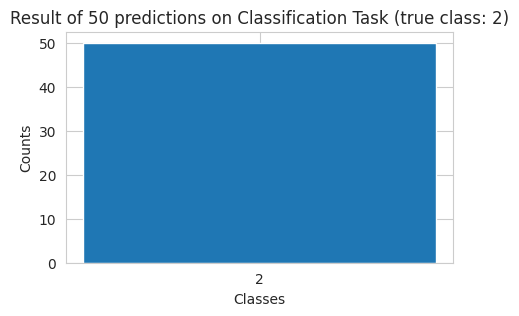

In [875]:
plot_ensemble(losses_wine, predictions_wine, y_test_wine, classification = True)

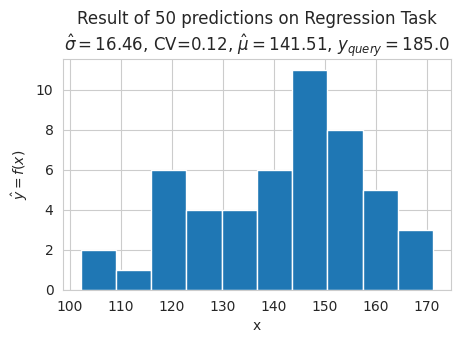

In [876]:
plot_ensemble(losses_diabetes, predictions_diabetes, y_test_diabetes, classification = False)

### Experiment IV (predict mean and std)